## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

### Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import pickle
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
## Some Extra Lib

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Libraries for text preprocessing
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
# from subprocess import check_output
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Libraries for machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [138]:
## Setting displays for rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# filter Warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab Notebooks/complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

### Data preparation

In [6]:
# checking the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

##### There are many columns with missing values.
##### There is only one numerical column: _score.

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
df.shape

(78313, 22)

##### The dataset has 78,313 customer complaints and 22 features.

##### The customer complaint is in "_source.complaint_what_happened" column

In [9]:
# printing the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

##### The score column has all values as 0.0

In [10]:
# Inspect the number of missing values
df.isna().sum(0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

##### There are so many missing values. But, they are not required in model building. Let's leave them as it is.

### Data Cleaning

In [11]:
# Assign new column names
# Remove leading underscore from all columns
df.columns = [re.sub('^_','', col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [12]:
#We will remove beginner word soruce from all the columns 
df.columns = [re.sub(r"^\bsource\b\.","",col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [13]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
df['complaint_what_happened'].isna().sum()

0

In [15]:
len(df[df['complaint_what_happened'] == ""])

57241

##### 57,241 rows in the data have blanks under complaints column.

In [16]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace= True)

In [17]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace = True)

In [18]:
len(df[df['complaint_what_happened'] == ""])

0

##### New dataset after removing null complaints

In [19]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [137]:
## View of complaint column
df['complaint_what_happened'].head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [21]:
# Function to clean the text and remove all the unnecessary elements.

def clean_doc(text):
    '''This Function 
      - Makes all words in lower case
      - Removes Text in []
      - Removes words containing numbers & removes punctuation. 
    :param text: text to be cleaned
    :return: cleaned text'''
    
    #Makes it to lower case 
    text = text.lower()
    
    #Removes text in ["square bracket"]
    text = re.sub(r'\[.*?\]', '', text)
    
    #Removes punctuations
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    #Removes words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
      
    return text

In [22]:
# Apply fun clean_doc on complaint column & make a new DF out of it having clean_doc text
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_doc(x)))

In [23]:
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [24]:
#Function to Lemmatize the texts

def lemmatizer(text):     
    """
    This function lemmatizes the given input text.
    :param text: given text
    :return: lemmatized text
    """
    
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)


In [25]:
#Created a dataframe('df_clean') that have only the complaints and the lemmatized complaints 

df_clean["lemmatized_complaints"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...


In [29]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
#Write your function to extract the POS tags 
def get_singular_nouns(text):
    """
    This function extracts the singular nouns from given text
    :param: input text
    :return: extracted nouns from the input text
    """
    
    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# Apply the function to create a new column containing only singular nouns 
# We don't have plural nouns as the text is already lemmatized
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_nouns(x['lemmatized_complaints']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...


In [31]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [32]:
# Code to visualise the data according to the 'Complaint' character length
doc_lengths = [len(d) for d in df_clean['complaint_POS_removed']]
doc_lengths[:10]

[192, 102, 74, 446, 192, 7, 699, 652, 1322, 51]

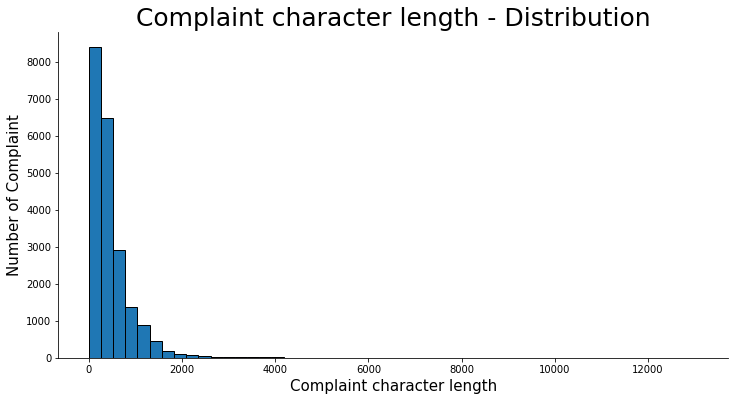

In [33]:
# Plot the data according to character length of complaints
plt.figure(figsize=(12,6))
plt.hist(doc_lengths, edgecolor='black', bins = 50)
plt.title('Complaint character length - Distribution', fontsize=25)
plt.ylabel('Number of Complaint', fontsize=15)
plt.xlabel('Complaint character length', fontsize=15)
sns.despine()
plt.show()

#### The distribution of word counts is skewed a little positive but overall it is a pretty mormal distribution

#### Find the top 40 words by frequency among all the articles after processing the text.

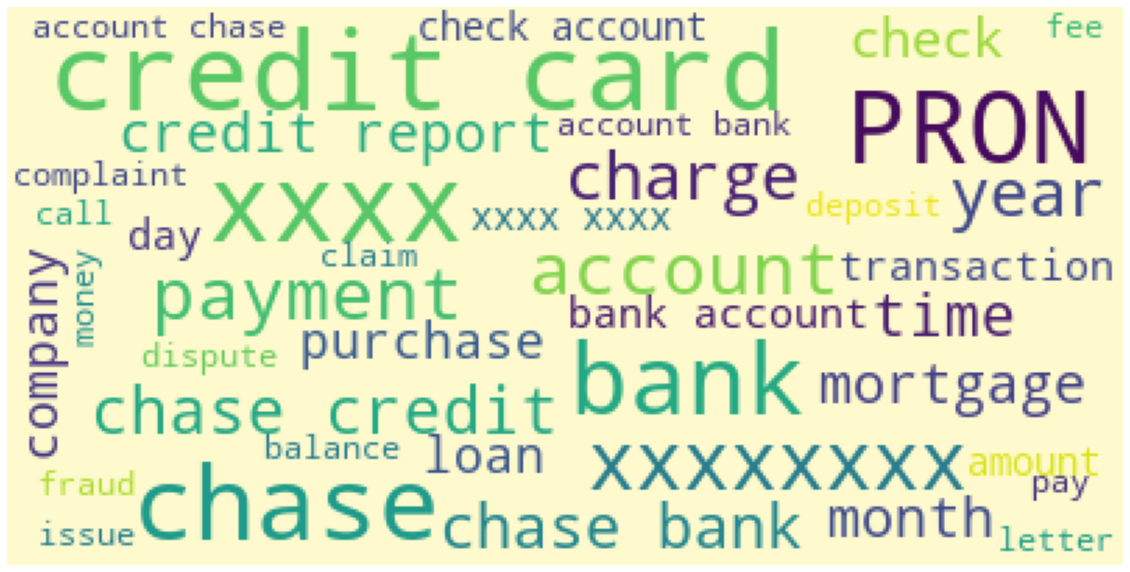

In [34]:
#Using a word cloud top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [35]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [36]:
#Code to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_n_words(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n words(unigrams) among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top words(unigrams) to find
    :return: list of tuples with two elements each: the word and its frequency
    """
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

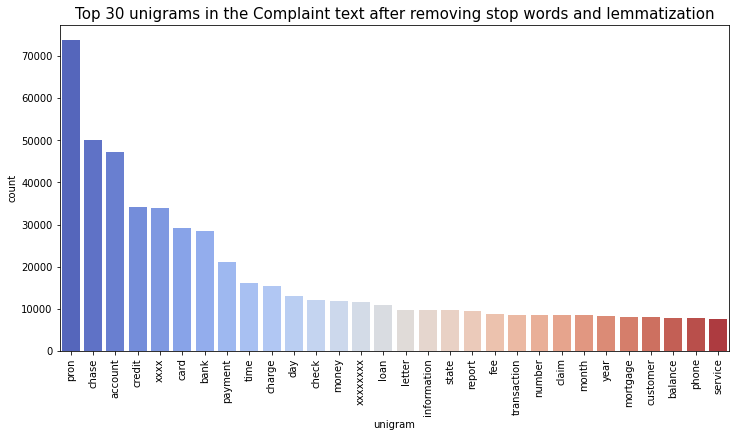

In [37]:
# Top 30 unigrams by frequency among all the complaints
common_words = get_top_n_words(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(12,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=15)
plt.show()

In [38]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,pron,73660
1,chase,50015
2,account,47168
3,credit,34149
4,xxxx,34013
5,card,29071
6,bank,28392
7,payment,21159
8,time,16025
9,charge,15539


In [39]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_n_bigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n bigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top bigrams to find
    :return: list of tuples with two elements each: the bigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

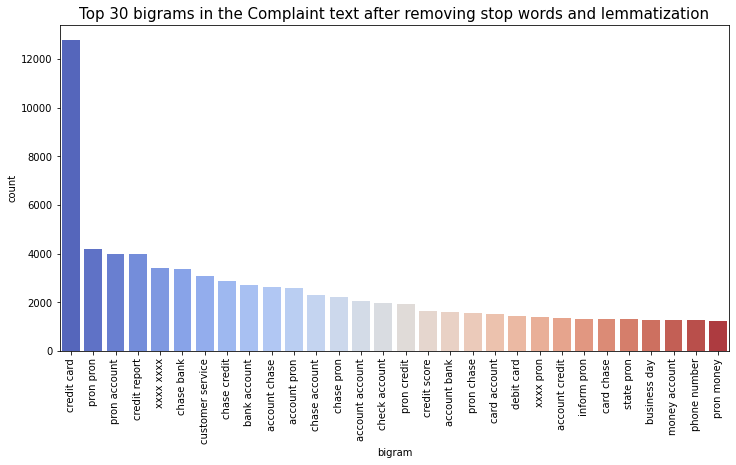

In [40]:
common_words = get_top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(12,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=15)
plt.show()

In [41]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12765
1,pron pron,4182
2,pron account,3998
3,credit report,3979
4,xxxx xxxx,3411
5,chase bank,3360
6,customer service,3078
7,chase credit,2889
8,bank account,2690
9,account chase,2628


In [42]:
#Code to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n trigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top trigrams to find
    :return: list of tuples with two elements each: the trigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

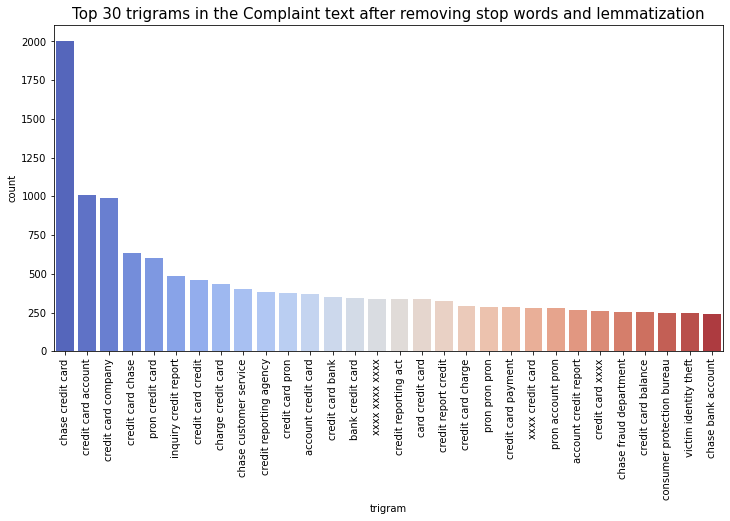

In [43]:
#Plotting for Trigram
common_words = get_top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(12,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=15)
plt.show()

In [44]:
# Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2005
1,credit card account,1006
2,credit card company,988
3,credit card chase,633
4,pron credit card,605
5,inquiry credit report,488
6,credit card credit,460
7,charge credit card,436
8,chase customer service,403
9,credit reporting agency,381


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [45]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [46]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket i offer ticket card i informa...,try book xxxx ticket i offer ticket card i inf...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...


In [48]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [49]:
#Code to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [50]:
#Code to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [51]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

#### To select best number of Topics, we will use Coherence Model
##### With the Coherence Model we will see how to automatically select the best number of topics. 

In [64]:
pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 55.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [80]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter


# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


In [81]:
#Load your nmf_model with the n_components i.e 5 & random_state =40
nmf_model = NMF(n_components=5, random_state=40)

In [82]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7402

In [83]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'pron', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'pron', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['sale', 'foreclosure', 'house', 'document', 'rate', 'time', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'pron', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC #3
['statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'transaction', 'dispute', 'chase', 'pron', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['year', 'error', 'chase', 'account', 'credit', 'time', 'date', 'auto', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']




In [84]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([2, 1, 1, ..., 3, 4, 4])

In [88]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topics'] = topic_results.argmax(axis=1)

In [89]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic,Topics
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,2,2
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket i offer ticket card i informa...,try book xxxx ticket i offer ticket card i inf...,1,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0,0


In [90]:
#Print the first 5 Complaint for each of the Topics
df_clean_gr=df_clean.groupby('Topics').head(5)
df_clean_gr.sort_values('Topics')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic,Topics
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict -PRON...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,0,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,mishandle account auto xxxx,0,0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,i account bank code bonus i term everything ac...,i account bank code bonus i term everything ac...,0,0
35,i opened the saving account for the bonus i w...,i open the saving account for the bonus i be...,i account bonus i bonus auto transfer check no...,i account bonus i bonus auto transfer check no...,0,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket i offer ticket card i informa...,try book xxxx ticket i offer ticket card i inf...,1,1
15,can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [91]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

# Replace Topic Names with Topic numbers
df_clean['Topics'] = df_clean['Topics'].map(Topic_names)

In [92]:
df_clean.shape

(21072, 6)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [93]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topic Names with Topic numbers
df_clean['Topics'] = df_clean['Topics'].map(Topic_names)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic,Topics
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,2,2
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket i offer ticket card i informa...,try book xxxx ticket i offer ticket card i inf...,1,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0,0


In [94]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaint_what_happened","Topics"]]

In [95]:
training_data

Output hidden; open in https://colab.research.google.com to view.

In [96]:
training_data.shape

(21072, 2)

In [97]:
# View value counts of the five topics
training_data['Topics'].value_counts()

0    5186
3    5042
1    4747
2    3989
4    2108
Name: Topics, dtype: int64

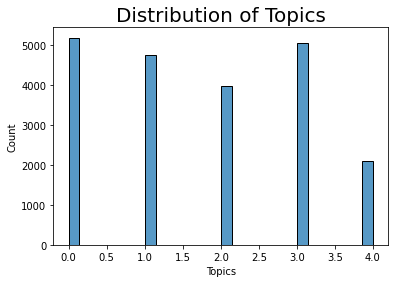

In [98]:
# Plot a histogram of classes (i.e. topics)
sns.histplot(data=training_data, x='Topics')
plt.title("Distribution of Topics", fontsize=20)
plt.show()

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [99]:
#Write your code to get the Vector count
# Get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

In [100]:
# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [101]:
# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [129]:
# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [104]:
# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topics, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33599)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33599)
Shape of y_test: (5268,)


You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [105]:
# Create a function to evaluate different models
def eval_model(y_test, y_pred, model_name):
    """
    This function prints the classification report of a classifier 
    and plots the confusion martrix
    :param y_test: actual labels
    :param y_pred: predicted labels
    :param model_name: the name of the model being evaluated
    :return: None
    """
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

#### LOGISTIC Regression





In [106]:
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')

clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs


In [107]:
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.919119430085213

In [133]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

clf_lr_tuned.fit(X_train, y_train)
pickle.dump(clf_lr_tuned, open("logreg_model.pkl","wb"))

y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

In [109]:
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9386990502008532

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.95      0.95      1305
Credit card or prepaid card       0.95      0.94      0.94      1224
                     Others       0.93      0.93      0.93       967
    Theft/Dispute Reporting       0.92      0.93      0.93      1247
              Mortgage/Loan       0.94      0.94      0.94       525

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



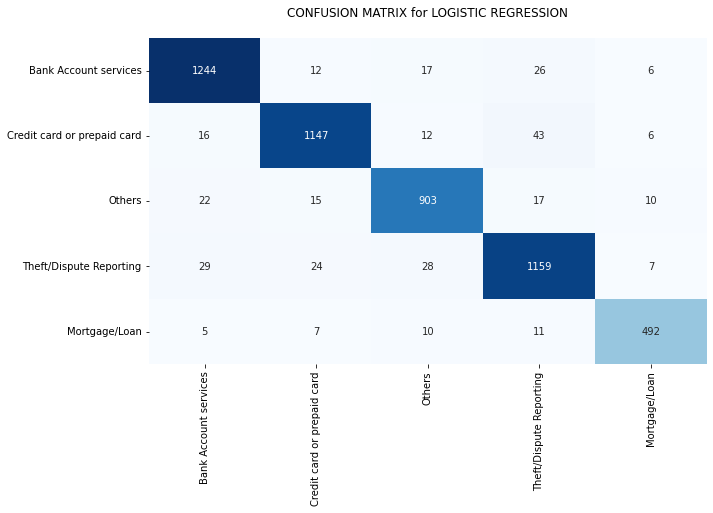

In [110]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

In [111]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'LOGISTIC REGRESSION','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,LOGISTIC REGRESSION,0.92,0.94


#### Decision Tree

In [112]:
# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()

clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [113]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7735742465416372

In [ ]:
# Hyperparameter tuning to improve Decision Tree performance
# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth' : [5, 10, 15, 20, 25, 30],
#     'min_samples_leaf':[1,5,10,15, 20, 25],
#     'max_features':['auto','log2','sqrt',None],
# }

# grid_dt = GridSearchCV(estimator=clf_dt, 
#                        param_grid=param_grid_dt,
#                        verbose=1,
#                        scoring='f1_weighted',
#                        n_jobs=-1,
#                        cv=5)
# grid_dt.fit(X_train, y_train)
# print(grid_dt.best_params_)

In [114]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)

clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [115]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.7947447404933348

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.82      0.81      1305
Credit card or prepaid card       0.84      0.82      0.83      1224
                     Others       0.81      0.81      0.81       967
    Theft/Dispute Reporting       0.75      0.75      0.75      1247
              Mortgage/Loan       0.78      0.74      0.76       525

                   accuracy                           0.79      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.80      0.79      0.79      5268



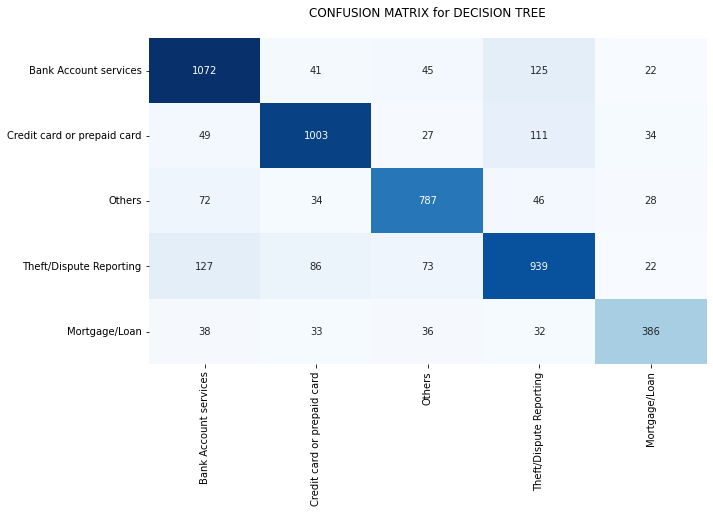

In [116]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

In [117]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,LOGISTIC REGRESSION,0.92,0.94
1,Decision Tree,0.77,0.79


#### Random Forest

In [118]:
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [119]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.798664157034679

In [120]:
# Hyperparameter tuning to improve Random Forest performance
# param_grid_rf = {
#     'n_estimators': [100, 200, 300, 500, 800],
#     'criterion':['gini','entropy'],
#     'max_depth': [10, 30, 40],
#     'min_samples_split': [1, 5, 10],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['log2', 'sqrt', None]    
# }

# grid_rf = RandomizedSearchCV(estimator=clf_rf, 
#                        param_distributions=param_grid_rf,
#                        scoring='f1_weighted',
#                        verbose=1,
#                        n_jobs=-1,
#                        cv=5)
# grid_rf.fit(X_train, y_train)
# print(grid_rf.best_params_)

In [121]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)

clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [122]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8401631266301024

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.83      0.86      0.85      1305
Credit card or prepaid card       0.87      0.85      0.86      1224
                     Others       0.86      0.84      0.85       967
    Theft/Dispute Reporting       0.81      0.81      0.81      1247
              Mortgage/Loan       0.83      0.83      0.83       525

                   accuracy                           0.84      5268
                  macro avg       0.84      0.84      0.84      5268
               weighted avg       0.84      0.84      0.84      5268



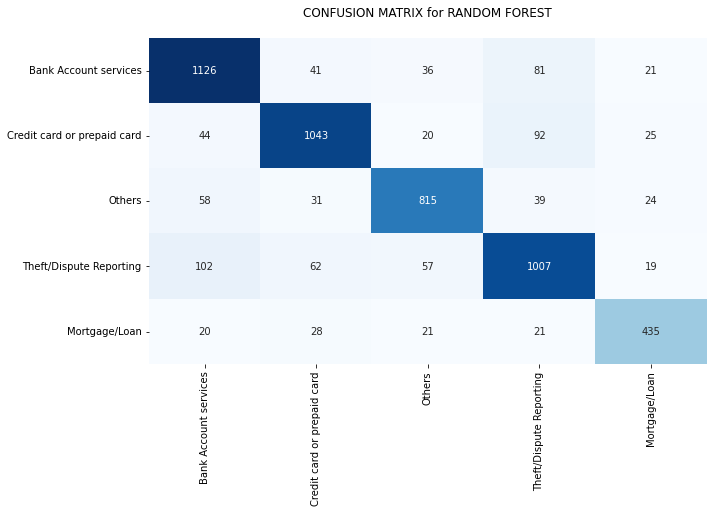

In [123]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

In [128]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,LOGISTIC REGRESSION,0.92,0.94
1,Decision Tree,0.77,0.79
2,Random Forest,0.80,0.84
3,Random Forest,0.80,0.84


### Model Inference 

In [134]:
# Function to predict a topic for given text

def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("/content/count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("/content/tfidf.pkl","rb"))
    loaded_model = pickle.load(open("/content/logreg_model.pkl","rb"))

    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]



In [141]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "can you please remove inquiry",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new

,complaints
0,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,can you please remove inquiry
5,I need to know the number of bank branches and their locations in the city of Dubai


In [142]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Credit card or prepaid card
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card or prepaid card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
4,can you please remove inquiry,Credit card or prepaid card
5,I need to know the number of bank branches and their locations in the city of Dubai,Bank Account services


#### Conclusion - Model performs good in classifying the text.